In [1]:
import os
import json
import warnings
import re
import pandas as pd
import numpy as np

from sys import getsizeof

import nltk # version 3.2.5
from nltk import pos_tag
import emoji # version 0.4.5
from profanity import profanity # version 1.1
from wordcloud import WordCloud 
from collections import Counter
from toolz import valfilter

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')
nltk.download('stopwords');
nltk.download('vader_lexicon')

NEG_DATA_PATH = '../twitter-datasets/train_neg_full.txt'
POS_DATA_PATH = '../twitter-datasets/train_pos_full.txt'
# NEG_DATA_PATH = '../twitter-datasets/train_neg.txt'
# POS_DATA_PATH = '../twitter-datasets/train_pos.txt'

[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Read and Treat Data

In [2]:
def read_json(path):
    lines = []
    with open(path, "r") as doc:
        for line in doc:
            lines.append(line)
    return lines

In [3]:
pos = read_json(POS_DATA_PATH)
pos_tokens = [x.split() for x in pos]
raw_pos = pd.DataFrame(list(zip(pos, pos_tokens)), columns=['raw_tweet', 'tokens'])
raw_pos['score'] = 1
neg = read_json(NEG_DATA_PATH)
neg_tokens = [x.split() for x in neg]
raw_neg = pd.DataFrame(list(zip(neg, neg_tokens)), columns=['raw_tweet', 'tokens'])
raw_neg['score'] = -1
raw_tweets = pd.concat([raw_pos, raw_neg], axis=0)

In [4]:
def tweets_metrics(df):
    df['count_user'] = df['raw_tweet'].str.count('<user>')
    df['count_url'] = df['raw_tweet'].str.count('<url>')
    df['count_!'] = df['raw_tweet'].str.count('!')
    df['count_?'] = df['raw_tweet'].str.count('\?')
    df['count_#'] = df['raw_tweet'].str.count('#')
    df['count_<3'] = df['raw_tweet'].str.count('<3')
    df['count_lol'] = df['raw_tweet'].str.count('lol')
    df['count_words'] = df['clean_tweet'].str.split().str.len()
    
    # emojis
    emojis_list = map(lambda x: 
                      ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
    regex_emojis = re.compile('|'.join(re.escape(p) 
                                       for p in emojis_list))
    df['count_emojis'] = df['raw_tweet'].str.count(regex_emojis)
    
    # bad words
    regex_bad = re.compile('|'.join(re.escape(p) 
                                       for p in profanity.get_words()))
    
    df['count_profanity'] = df['clean_tweet'].str.count(regex_bad)
                            
    return df

In [5]:
raw_tweets['clean_tweet'] = raw_tweets['raw_tweet']
raw_tweets = tweets_metrics(raw_tweets)

# Tag Analysis
The goal is analyse the amount of `{verbs, adjectives, adverbes and nouns}` by tweet score

In [7]:
 def lookup_type_word(type_word):
        if type_word.startswith('J'):
            return 'adj'
        elif type_word.startswith('V'):
            return 'verb'
        elif type_word.startswith('N'):
            return 'noun'
        elif type_word.startswith('R'):
            return 'adv'
        else:
            return None

In [8]:
def count_tags(tokens_series):
    """
    Function classify token in (verb, adj, adv, noun)
    :param tokens_series: series of tokens
    :return: dataframe with token classified and proportion of each category
    """
    tags_series = tokens_series.apply(lambda tokens: list(map(lambda t:
                                                              lookup_type_word(t[1]),
                                                              pos_tag(tokens))))

    prop_verbs = (tags_series
                  .apply(lambda tag:
                         len([x for x in tag if x == 'verb']) / len(tag) if len(tag) > 0 else 0))

    prop_adj = (tags_series
                .apply(lambda tag: len([x for x in tag if x == 'adj']) / len(tag) if len(tag) > 0 else 0))

    prop_adv = (tags_series
                .apply(lambda tag: len([x for x in tag if x == 'adv']) / len(tag) if len(tag) > 0 else 0))

    prop_noun = (tags_series
                 .apply(lambda tag: len([x for x in tag if x == 'noun']) / len(tag) if len(tag) > 0 else 0))

    return pd.DataFrame({'prop_verbs': prop_verbs,
                         'prop_adj': prop_adj,
                         'prop_adv': prop_adv,
                         'prop_noun': prop_noun})

In [9]:
tags = count_tags(raw_tweets['tokens'])
raw_tweets = pd.concat([raw_tweets, tags], axis=1)

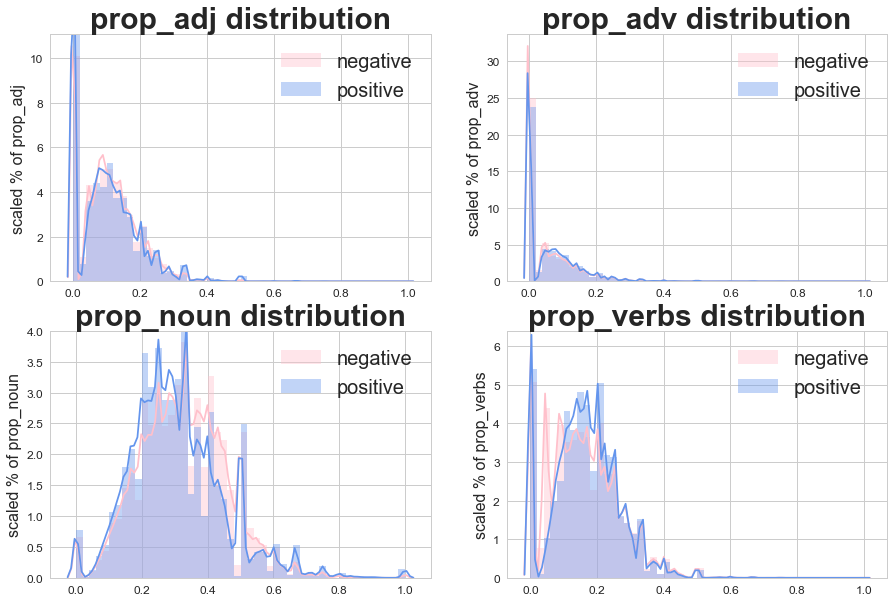

In [32]:
numeric_features = ['prop_adj', 'prop_adv', 'prop_noun', 'prop_verbs']

f, ax = plt.subplots(2, 2, figsize=(15, 10))
positions = np.array(range(4)).reshape(2, 2)

for num_c, c in enumerate(numeric_features):
    pos = np.where(positions==num_c)
    sns.distplot(raw_tweets[raw_tweets.score == -1][c], color='pink', ax=ax[pos[0][0], pos[1][0]])
    sns.distplot(raw_tweets[raw_tweets.score == 1][c], color='cornflowerblue', ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title('{} distribution'.format(c), fontsize=30, fontweight="bold")
    ax[pos[0][0], pos[1][0]].legend(loc='upper right')
    ax[pos[0][0], pos[1][0]].legend(['negative', 'positive'], loc='best', fontsize=20);
    ax[pos[0][0], pos[1][0]].set_ylabel("scaled % of {}".format(c), fontsize=16)
    ax[pos[0][0], pos[1][0]].set_xlabel('')
    
    plt.savefig('figures/distribution_tags_by_score.png')
    ax;

# Sentimental Analysis with Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a tool with lexicon for sentimental analysis and it is tunned and performs very well in social media.
The paper with more informations about who it is calculated and the performance can be found [here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf?lipi=urn%3Ali%3Apage%3Ad_flagship3_pulse_read%3BbAUS6s97R5uxMEV9nK7ePw%3D%3D). 

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

raw_tweets['sentimental_scores'] = pd.DataFrame(raw_tweets['clean_tweet'].apply(lambda x: sid.polarity_scores(x)))
raw_tweets['negative_score'] = raw_tweets['sentimental_scores'].apply(lambda x: x['neg'])
raw_tweets['positive_score'] = raw_tweets['sentimental_scores'].apply(lambda x: x['pos'])
raw_tweets['neutral_score'] = raw_tweets['sentimental_scores'].apply(lambda x: x['neu'])
raw_tweets['compound_score'] = raw_tweets['sentimental_scores'].apply(lambda x: x['compound'])

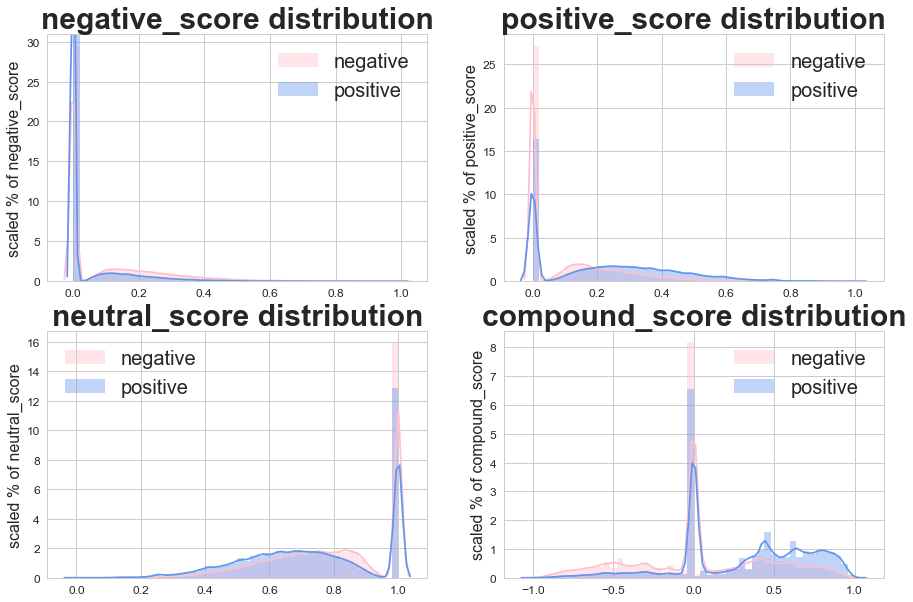

In [33]:
numeric_features = ['negative_score', 'positive_score', 'neutral_score', 'compound_score']

f, ax = plt.subplots(2, 2, figsize=(15, 10))
positions = np.array(range(4)).reshape(2, 2)

for num_c, c in enumerate(numeric_features):
    pos = np.where(positions==num_c)
    sns.distplot(raw_tweets[raw_tweets.score == -1][c], color='pink', ax=ax[pos[0][0], pos[1][0]])
    sns.distplot(raw_tweets[raw_tweets.score == 1][c], color='cornflowerblue', ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title('{} distribution'.format(c), fontsize=30, fontweight="bold")
    ax[pos[0][0], pos[1][0]].legend(loc='upper right')
    ax[pos[0][0], pos[1][0]].legend(['negative', 'positive'], loc='best', fontsize=20);
    ax[pos[0][0], pos[1][0]].set_ylabel("scaled % of {}".format(c), fontsize=16)
    ax[pos[0][0], pos[1][0]].set_xlabel('')
    
    plt.savefig('figures/sentiments_by_score.png')

    ax;

# Sentimental Analysis with NRC Emotion Lexicon

The [database](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) in not avaiable any more according to [here](http://saifmohammad.com/WebPages/AccessResource.htm). I just sent a email but I'm sure if they will answer quickly. So sad!


# Model with non-text features
Features selected based on descriptive analysis and to avoid redundance

In [25]:
features = ['count_url', 'count_words', 'count_lol', 'count_user', 
            'negative_score', 'positive_score', 'compound_score', 
            'prop_adj', 'prop_adv', 'prop_verbs']

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50,
                             max_depth=10, 
                             oob_score=True)

In [27]:
clf.fit(raw_tweets[features], raw_tweets['score']);

In [28]:
def plot_importance_rf(clf, features):
    importances = clf.feature_importances_
    feat_importance = (pd.DataFrame(list(zip(features, importances)), 
                               columns=['feature', 'importance'])
                  .sort_values('importance', ascending=False))
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.barplot(y='feature', x='importance', 
                     data=feat_importance,
                     saturation=0.8)
    ax.set_title('Feature Importance by word', fontsize=18)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.xlabel('Importance', fontsize=14); plt.ylabel('Feature', fontsize=14);
    print('Out-of-bag score: {s}%'.format(s=100*round(clf.oob_score_, 3)));
    ax;

Out-of-bag score: 73.8%


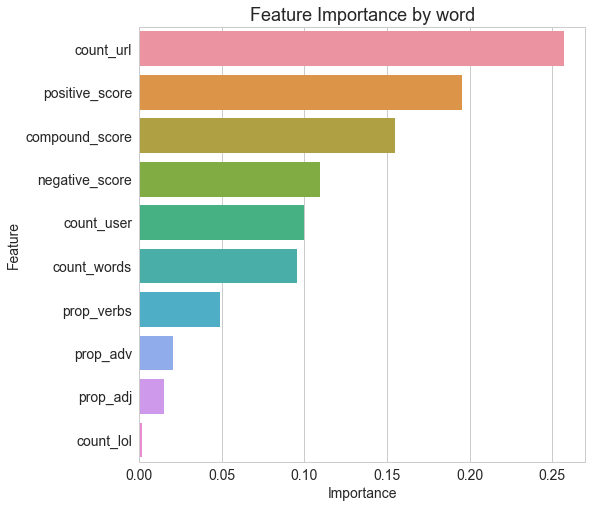

In [30]:
plot_importance_rf(clf, features)

# TF-IDF